## Model Selection and Training

Once a model is selected,it needs to be trained before applied to real world solutions.
Data is first split into training and testing dataset used to evaluate performance of model, which is then exposed to the test data.  

![data_training](https://github.com/mikemwanga/training-requirements/blob/main/Extra_Training/ML_with_SkillCurb/Images/data_trainining.png)

Dataset can be chosen through serial splitting or random selection (80% to 20%)
Here we demonstrate how to select a particular model and train it.

In [1]:
#Import  libraries for use
#analysis
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns

#visualization
import matplotlib.pyplot as plt
%matplotlib inline 
%pylab inline

import plotly as pltx

#ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score # for accuracy score
from sklearn.model_selection import KFold #  for cross validation
from sklearn.model_selection import cross_val_score #for evaluating cross validation score
from sklearn.model_selection import cross_val_predict # for prediction
from sklearn.metrics import confusion_matrix # for confussion



Populating the interactive namespace from numpy and matplotlib


Read in the data

**Aim is to predict those who survived in the test dataset. The train dataset has *survived* variable which is missing in the test dataset** 

In [2]:
train_df = pd.read_csv("./data/titanic/train.csv")
test_df = pd.read_csv("./data/titanic/test.csv")

train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Some features such as **Cabin** and **ticket** are not needed and will be dropped in the next step. The create a new feature

In [3]:
#train_df = train_df.drop(["Ticket","Cabin"], axis=1)
#test_df = test_df.drop(["Ticket","Cabin"], axis=1)
combine = [test_df, train_df]

for dataset in combine:
    dataset["Title"] = dataset.Name.str.extract( "([A-Za-z]+)\.", expand=False)

pd.crosstab(train_df["Title"], train_df["Sex"])


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Also replace titles with more common names types. 

The group the survived by title and determine the mean.

In [4]:
for dataset in combine:
    dataset["Title"] = dataset["Title"].replace(["Lady","Countess","Capt","Col","Don", \
        "Dr","Major", "Rev","Sir", "Jonkheer","Dona"], "Rare")
    dataset["Title"] = dataset["Title"].replace("Mlle", "Miss")
    dataset["Title"] = dataset["Title"].replace("Ms", "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")

train_df[["Title", "Survived"]].groupby(["Title"], as_index=False).mean()


,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Convert the categorical titles to ordinal.

In [5]:
title_mapping = {"Mr" : 1, "Miss" : 2, "Mrs" : 3, "Master" : 4, "Rare" : 5}

for dataset in combine:
    dataset["Title"] = dataset["Title"].map(title_mapping)
    dataset["Title"] = dataset["Title"].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


We can then drop the name feature and passengerId because they dont add any infor.

In [6]:
train_df = train_df.drop(["Name", "PassengerId","Cabin"], axis=1)
test_df = test_df.drop(["Name","Cabin"], axis=1)

combine = [train_df, test_df]



### Convert string value to numericals
The gender data needs to be converted to numberics men=0, female=1

In [7]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map({"female" : 1, "male" : 0}).astype(int)


#### Missing value treatment

Working on the mising values in the Age feature. Visualize age in Pclass and Sex and bin accordingly.

In [8]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,0,3,0,22.0,1,0,A/5 21171,7.2500,S,1
1,1,1,1,38.0,1,0,PC 17599,71.2833,C,3
2,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,S,2
3,1,1,1,35.0,1,0,113803,53.1000,S,3
4,0,3,0,35.0,0,0,373450,8.0500,S,1


/Users/mikemwanga/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


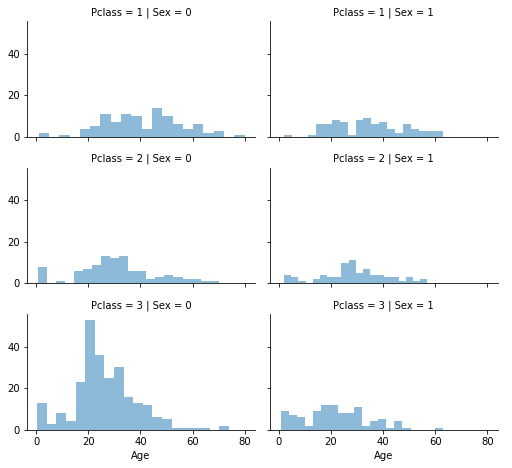

In [9]:
grid = sns.FacetGrid(train_df, row='Pclass', col="Sex", size=2.2,aspect=1.6)
grid.map(plt.hist, "Age", alpha=0.5, bins=20)
grid.add_legend()

Figures shows variation in age when you compare Pclass and gender. 
So lets prepare and empty array containing sex and age values and fill in the medians of ages in relation to gender.
Iterate over Sex(0,1) and Pclass(1,2,3) to calculate guessed values of age as per the six combinations.

In [10]:
guess_ages = np.zeros((2,3))

for dataset in combine:
    for i in range(0,2):
        for j in range(0,3):
            guess_df = dataset[ (dataset["Sex"] == i) &  (dataset["Pclass"] ==j+1)]["Age"].dropna()
            age_guess = guess_df.median() #create a median for each category

            guess_ages[i,j] = (age_guess/0.5 + 0.5) * 0.5 #round off to .5

    #now create a new dataset and replace the missing values for each category with medians of guessed age groups
    for i in range(0,2):
        for j in range(0,3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), "Age"] = guess_ages[i,j]
    dataset["Age"] = dataset["Age"]



train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Embarked  889 non-null    object 
 9   Title     891 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 69.7+ KB


In [11]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,0,3,0,22.0,1,0,A/5 21171,7.2500,S,1
1,1,1,1,38.0,1,0,PC 17599,71.2833,C,3
2,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,S,2
3,1,1,1,35.0,1,0,113803,53.1000,S,3
4,0,3,0,35.0,0,0,373450,8.0500,S,1


In [12]:
for dataset in combine:
    dataset["IsAlone"] = 0 #create an IsAlone feature

    dataset.loc[dataset["SibSp"] == 0,"IsAlone"] = 1 #Individuals with no siblings or spouse will be counted in the Isalone feature

train_df[["IsAlone", "Survived"]].groupby(["IsAlone"], as_index=False).mean() #determine chance of survival for this category

,IsAlone,Survived
0,0,0.466431
1,1,0.345395


We've extracted meaningful information and we can drop deatues that are unncessary *Parch, Sibsp*

Embarked does have alot of missing featues which are in categorical format. How do we fill in the missing values? Embarked takes in S,Q and C values and since only two values are missing we can fill with the most common feature using mode. Also convert the categorical embarked feature to new categorical features.

In [13]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

for dataset in combine:
    dataset["Embarked"] = dataset["Embarked"].fillna(freq_port) #replace missing values with most frequent

train_df[["Embarked","Survived"]].groupby(["Embarked"],as_index=False).mean().sort_values(by="Survived")


,Embarked,Survived
2,S,0.339009
1,Q,0.389610
0,C,0.553571


Map the Embarked feature to numeric values

In [14]:
for dataset in combine:
    dataset["Embarked"] = dataset["Embarked"].map({"S" : 0 , "C" : 1, "Q" : 2}).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,IsAlone
0,0,3,0,22.0,1,0,A/5 21171,7.2500,0,1,0
1,1,1,1,38.0,1,0,PC 17599,71.2833,1,3,0
2,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,0,2,1
3,1,1,1,35.0,1,0,113803,53.1000,0,3,0
4,0,3,0,35.0,0,0,373450,8.0500,0,1,1


In the test dataset, missing value exists with the fare feature. We can use median to get the most frequent value and replace 

In [15]:
freq_fare = test_df.Fare.dropna().median()

test_df["Fare"] = test_df["Fare"].fillna(freq_fare)

test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,IsAlone
0,892,3,0,34.5,0,0,330911,7.8292,2,1,1
1,893,3,1,47.0,1,0,363272,7.0000,0,3,0
2,894,2,0,62.0,0,0,240276,9.6875,2,1,1
3,895,3,0,27.0,0,0,315154,8.6625,0,1,1
4,896,3,1,22.0,1,1,3101298,12.2875,0,3,0


Convert fare into numeric by creating 4 bands
<7.91 = 0
7.94 - 14.454 = 1


In [16]:
train_df["FareBand"] = pd.cut(train_df["Fare"],4) #creates the 4 bands

train_df[["FareBand","Survived"]].groupby(["FareBand"], as_index=False).mean().sort_values(by="FareBand")


,FareBand,Survived
0,"(-0.512, 128.082]",0.368113
1,"(128.082, 256.165]",0.724138
2,"(256.165, 384.247]",0.666667
3,"(384.247, 512.329]",1.000000


In [17]:
for dataset in combine:
    dataset.loc[dataset["Fare"] <=7.91, "Fare"] = 0
    dataset.loc[(dataset["Fare"] > 7.91) & (dataset["Fare"] <= 14.454), "Fare"] = 1
    dataset.loc[(dataset["Fare"] > 14.454) & (dataset["Fare"] <= 31), "Fare"] = 2
    dataset.loc[dataset["Fare"] > 31, "Fare"] = 0
    dataset["Fare"] = dataset["Fare"].astype(int)

train_df = train_df.drop(["FareBand"], axis=1)


combine = [train_df,test_df]

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,IsAlone
0,0,3,0,22.0,1,0,A/5 21171,0,0,1,0
1,1,1,1,38.0,1,0,PC 17599,0,1,3,0
2,1,3,1,26.0,0,0,STON/O2. 3101282,1,0,2,1
3,1,1,1,35.0,1,0,113803,0,0,3,0
4,0,3,0,35.0,0,0,373450,1,0,1,1


In [18]:
train_df = train_df.drop("Ticket", axis=1)
#test_df = test_df.drop("Ticket",axis=1)
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,IsAlone
0,892,3,0,34.5,0,0,330911,0,2,1,1
1,893,3,1,47.0,1,0,363272,0,0,3,0
2,894,2,0,62.0,0,0,240276,1,2,1,1
3,895,3,0,27.0,0,0,315154,1,0,1,1
4,896,3,1,22.0,1,1,3101298,1,0,3,0


### Model selection
Create train and test and validation datasets based on "Survived" feature


In [19]:
X_train = train_df.drop("Survived",axis=1)
Y_train = train_df["Survived"]
X_test = test_df.drop(["PassengerId","Ticket"], axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 9), (891,), (418, 9))

In [20]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,IsAlone
0,892,3,0,34.5,0,0,330911,0,2,1,1
1,893,3,1,47.0,1,0,363272,0,0,3,0
2,894,2,0,62.0,0,0,240276,1,2,1,1
3,895,3,0,27.0,0,0,315154,1,0,1,1
4,896,3,1,22.0,1,1,3101298,1,0,3,0


## Logistic regression model
Measures relationship between one categorical variable and one independent variable by estimating probabilitites using logistic functions.
Check Accuracy of function using score function. Also check correlation of features with target class.

In [21]:
logreg = LogisticRegression() #set the model function
logreg.fit(X_train, Y_train) #fit the model to the dataset
Y_pred = logreg.predict(X_test) #do the prediction
acc_log = round(logreg.score(X_train,Y_train)*100, 2)
acc_log

/Users/mikemwanga/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.15

In [22]:
#Check correlation of all features to Survival
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ["Feature"]
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.173700
7,Title,0.461853
6,Embarked,0.216608
5,Fare,0.005472
2,Age,-0.044496
4,Parch,-0.162729
8,IsAlone,-0.675349
3,SibSp,-0.681745
0,Pclass,-1.168424


Sex is a strongly correlated feature 

## Decission Tree model for prediction

In [23]:
decisiontree = DecisionTreeClassifier()

decisiontree.fit(X_train,Y_train) 

Y_predict = decisiontree.predict(X_test)

acc_decisiontree = round(decisiontree.score(X_train,Y_train) * 100, 2)

acc_decisiontree

95.29

## KNN Model prediction

In [24]:
knn = KNeighborsClassifier(n_neighbors=3) # set the parameter to 3 nearest neighbours
knn.fit(X_train, Y_train)
Y_predict = knn.predict(X_test) #perform prediction
acc_knn = round(knn.score(X_train, Y_train)*100,2) #check accuracy 
acc_knn

88.44

## Linear regression model prediction

In [25]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
Y_predict = lin_reg.predict(X_test)

acc_linreq = round(lin_reg.score(X_train,Y_train)*200,2)

acc_linreq


84.19

## Gaussian Model prediction

In [26]:
gausian  = GaussianNB()

gausian.fit(X_train, Y_train)
gausian_predict = gausian.predict(X_test)
acc_gausian  = round(gausian.score(X_train,Y_train)*100,2)

acc_gausian

81.14

Visualize model results

In [27]:
model_acc_results = pd.DataFrame({"Model" : ["Logistic Regression", "Decision Tree","KNN","Linear Regression","Naive Bayes"],
                                    "Score" : [acc_log,acc_decisiontree, acc_knn,acc_linreq,acc_gausian] })

model_acc_results = model_acc_results.sort_values(by="Score", ascending=False)

model_acc_results

,Model,Score
1,Decision Tree,95.29
2,KNN,88.44
3,Linear Regression,84.19
0,Logistic Regression,82.15
4,Naive Bayes,81.14


In [28]:
#Graphical display 

import plotly.express as pltx

fig = pltx.bar(model_acc_results,
               y="Model", x="Score",
               title = "Model accuracy",
               width = 800,height=400)
fig.show()

Decission tree model has outperformed all the models in this case.